In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# PyTorch uses 'nn.Module' as the base class for all neural network modules.
class TBHNN(torch.nn.Module):
    """
    Tight-binding Hamiltonian neural network
    """

    def __init__(self):
        super(TBHNN, self).__init__()
        self.H_size_added = 0
        # We will add more attributes and initializations as we convert other methods

    # Placeholder for read_training_set method, will be filled in later
    def read_training_set(self, references, k_vectors):
        num_k, num_b = references.shape
        self.num_b = num_b
        self.num_k = num_k
        self.H_size_init = num_b
        self.H_size = num_b
        self.references = torch.tensor(references, dtype=torch.float32, requires_grad=True)
        self.k_vectors = torch.tensor(k_vectors, dtype=torch.float32, requires_grad=True)
        # In PyTorch, tensors are automatically placed on the default device, so we don't
        # need to explicitly define device placement as in TensorFlow
        pass

    # Placeholder for define_TB_representation method, will be filled in later
    def define_TB_representation(self, vectors_without_opposite):
        # In PyTorch, we usually do not need to cast to complex inside class methods,
        # unless it is necessary for certain operations.
        num_r = len(vectors_without_opposite)
        self.num_r = num_r
        self.R = torch.nn.Parameter(torch.zeros((num_r, 3), dtype=torch.float32))

        # Then you can create a new tensor for R without in-place operations
        new_R_values = []
        for i, vector in enumerate(vectors_without_opposite):
            if not np.all(np.isclose(vector, 0.0)):
                new_R_values.append(torch.tensor(vector, dtype=torch.float32))
            else:
                new_R_values.append(torch.zeros(3, dtype=torch.float32))

        # Now you can concatenate the list of tensors into a single tensor
        new_R = torch.stack(new_R_values)

        # If 'self.R' needs to maintain its gradient, you should replace it with 'new_R' like so:
        self.R = torch.nn.Parameter(new_R)

        self.R_without_opposite = vectors_without_opposite

        pass

    # Placeholder for reinitialize method, will be filled in later
    def reinitialize(self):
        self.H_R = torch.nn.ParameterList()  # Use ParameterList instead of ModuleList
        self.H_size = self.H_size_init + self.H_size_added
        
        for _ in self.R_without_opposite:
            H_tmp = torch.nn.Parameter(torch.randn((self.H_size, self.H_size), dtype=torch.float32) * 0.1)
            self.H_R.append(H_tmp)
        pass

    # Placeholder for compute_bands method, will be filled in later
    def compute_bands(self):
        reproduced_bands = torch.zeros((self.num_k, self.H_size), dtype=torch.float32)
        
        for i in range(self.num_k):
            K = torch.zeros((self.H_size, self.H_size), dtype=torch.complex64)
            for j, H_R_component in enumerate(self.H_R):
                exp_factor = torch.exp(-1j * np.pi * torch.matmul(self.k_vectors[i], self.R[j]))
                K += exp_factor * H_R_component
                
            # Eigenvalues are computed from the Hermitian part of K to ensure they are real
            eigenvalues, _ = torch.linalg.eigh(K + K.conj().T)
            reproduced_bands[i] = eigenvalues.real

        # Sort the bands and discard those not needed for loss computation
        reproduced_bands = reproduced_bands[:, :self.H_size_init]
        self.bandstructure = reproduced_bands

        return reproduced_bands

In [32]:
def TBHCNN_stochastic_reset(mean_reset,threshold,stochastic):

    rvectors_without_opposite = np.array([[0,0,0],[0,0,1],], dtype=np.int32) # in units of[a, b, c] (a, b, and c are the real-space basis vectors; [l, n, m] means the lattice vector l*a+n*b+m*c)
    # Load training data
    references = np.load("./data/input/InSe Nanoribbon/InSe-references.npy")
    k_vectors = np.load("./data/input/InSe Nanoribbon/InSe-kpoints.npy") # in units of 1/2pi*[ak, bk, ck] (ak, bk, and ck are the corresponding k-space basis vectors; [l, n, m] means the k-vector (l/2pi)*ak+(n/2pi)*bk+(m/2pi)*ck)


    # Initialize the model
    tbhnn = TBHNN()
    tbhnn.read_training_set(references, k_vectors)
    tbhnn.define_TB_representation(rvectors_without_opposite)

    Loss_history = []
    resettings = [0]

    print("     ")
    print(f"Threshold = {threshold}")
    print(f"Average # step until resetting = {mean_reset}")
    print(f"Stochastic resetting ? {stochastic}")

    finished = False

    while not finished:
        tbhnn.reinitialize()
        print()
        optimizer = torch.optim.Adam(tbhnn.parameters(), lr=0.001)

        step_reset = int(mean_reset)
        
        if stochastic:
            step_reset = int(np.random.exponential(mean_reset))
        
        resettings.append(resettings[-1]+step_reset)

        for step in range(0,step_reset):
            optimizer.zero_grad()
            reproduced_bands = tbhnn.compute_bands()
            loss = torch.nn.SmoothL1Loss()(reproduced_bands, tbhnn.references)
            loss.backward()
            optimizer.step()
            Loss_history.append(loss.item())

            # if step % 1000 == 0:
            #     print(f"Step {step+resettings[-2]}, Loss: {loss.item()}")

            if loss.item() < threshold:
                finished = True
                resettings.pop()
                print(f"Convergence reached at step {resettings[-1]+step} for mean resetting step {mean_reset}")
                break

     
    #epochs visu. & Loss Function History plot
            
    plt.plot(Loss_history)
    plt.title(f"Loss Function History for {mean_reset} ")
    plt.xlabel("Step")
    plt.ylabel("Loss function value")
    plt.vlines(resettings,ymin=0.,ymax=np.max(Loss_history),linestyles="--",color="red",label="Resettings")
    plt.legend()
    #plt.ylim(bottom=np.min(Loss_history),top=0.005)
    plt.show()
    
    return(reproduced_bands,len(Loss_history))
    
    
    # Save the model if needed
    # torch.save(tbhnn.state_dict(), "path_to_model.pt")

#reproduced_bands, convergence = TBHCNN_stochastic_reset(500,1e-5)

     
Threshold = 0.005
Average # step until resetting = 600.0
Stochastic resetting ? True

Convergence reached at step 792 for mean resetting step 600.0


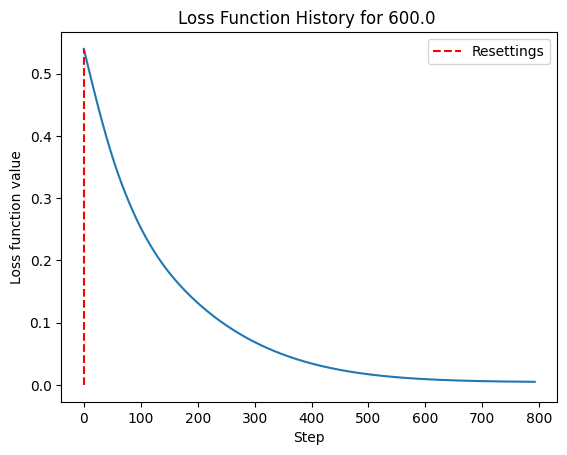

     
Threshold = 0.005
Average # step until resetting = 600.0
Stochastic resetting ? False

















KeyboardInterrupt: 

In [33]:
threshold = 5e-3
Samples = 5
Nb_means = 5
stochastic = True
deterministic = False

means = np.linspace(1000,2000,Nb_means)

convergences_sto = np.zeros([Nb_means,Samples],dtype=int)
convergences_deter = convergences_sto.copy()

for k,mean in enumerate(means):
    for s in range(Samples):
        convergences_sto[k,s] = TBHCNN_stochastic_reset(mean,threshold,stochastic)[1]
        convergences_deter[k,s] = TBHCNN_stochastic_reset(mean,threshold,deterministic)[1]

mean_convergences_sto = [np.mean(convergences_sto[i]) for i in range(Nb_means)]
mean_convergences_deter = [np.mean(convergences_deter[i]) for i in range(Nb_means)]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


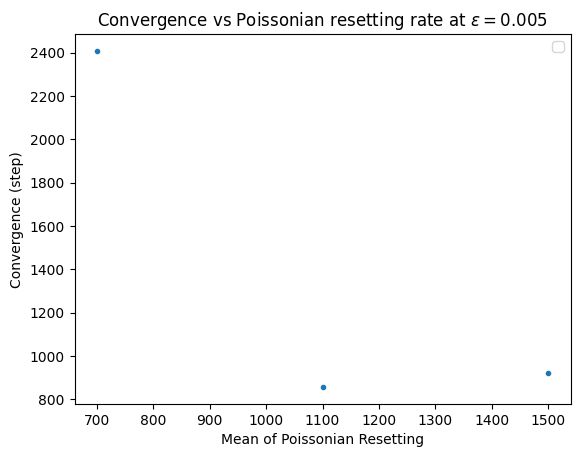

In [ ]:
plt.plot(means,mean_convergences_sto,"--",label="Stochastic resetting")
plt.plot(means,mean_convergences_sto,label="Deterministic resetting")
plt.xlabel("Mean of Poissonian Resetting")
plt.ylabel("Convergence (step)")
plt.title(f"Convergence vs Poissonian resetting rate at $\epsilon=${threshold}")
plt.legend()
plt.show()

In [ ]:
## With paper's parameters

stochastic = False
threshold = 1e-5
reproduced_bands_instance, Conv_time = TBHCNN_stochastic_reset(10000,threshold,stochastic)

reproduced_bands_np = reproduced_bands_instance.detach().numpy()
for band in range(reproduced_bands_np.shape[1]):
    plt.plot(reproduced_bands_np[:, band], label=f'Band {band+1}')

plt.xlabel('k-point Index')
plt.ylabel('Energy')
plt.title('Band Structure')
plt.legend()
plt.show()


     
Threshold = 1e-05
Average # step until resetting = 10000
stochastic resetting ? False

Step 0, Loss: 0.5976933240890503
Step 500, Loss: 0.025783006101846695


KeyboardInterrupt: 